In [1]:
import mne
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# path to this jupyter notebook
data_path = Path("../data/EEG")

participant_path = list((data_path / "sub-02").glob("*.vhdr"))[0]
raw = mne.io.read_raw_brainvision(str(participant_path), preload=True)

try:
    raw.set_channel_types({"EOG1": "eog", "EOG2": "eog"})
except ValueError:
    try:
        raw.set_channel_types({"VEOG": "eog", "HEOG": "eog"})
    except ValueError:
        pass

if "41" in raw.ch_names:
    raw.set_channel_types({"41": "misc"})

raw.filter(0.1, 40)        

# setting the reference    
raw.set_eeg_reference("average")

Extracting parameters from ../data/EEG/sub-02/Group12.vhdr...
Setting channel info structure...


/var/folders/6v/9wx2wvns3pzd3h_jgjzm673r0000gn/T/ipykernel_51004/3549452727.py:5: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = mne.io.read_raw_brainvision(str(participant_path), preload=True)


Reading 0 ... 1200119  =      0.000 ...  1200.119 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



/var/folders/6v/9wx2wvns3pzd3h_jgjzm673r0000gn/T/ipykernel_51004/3549452727.py:16: RuntimeWarning: The unit for channel(s) 41 has changed from V to NA.
  raw.set_channel_types({"41": "misc"})
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


Measurement date,"February 29, 2024 13:29:26 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,"30 EEG, 2 EOG, 1 misc"
Bad channels,None
EOG channels,"HEOG, VEOG"
ECG channels,Not available
Sampling frequency,1000.00 Hz
Highpass,0.10 Hz
Lowpass,40.00 Hz


Using matplotlib as 2D backend.


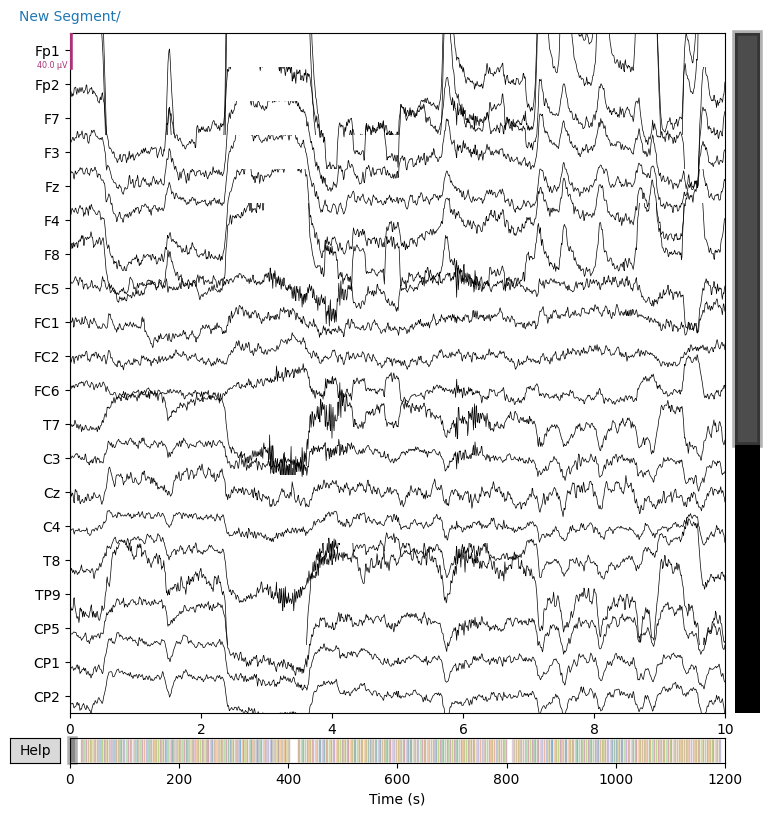

In [3]:
#raw = raw.pick(["eeg"])

# plot the eeg data
raw.plot();


Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 31', 'Stimulus/S 32', 'Stimulus/S 41', 'Stimulus/S 42', 'Stimulus/S 51', 'Stimulus/S 52', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S111', 'Stimulus/S112', 'Stimulus/S201', 'Stimulus/S202', 'Stimulus/S211', 'Stimulus/S212']
Not setting metadata
540 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 540 events and 701 original time points ...
    Rejecting  epoch based on EEG : ['F7', 'F8', 'FC5', 'FC6', 'T7']
    Rejecting  epoch based on EEG : ['F7', 'F8']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['F7', 'F8']
    Rejecting  epoch based on EEG : ['F7', 'F8', 'FC5', 'T7']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['F7', 'F8', 'FC5', 'FC6', 'T7', 'T8']
7 bad epochs dropped


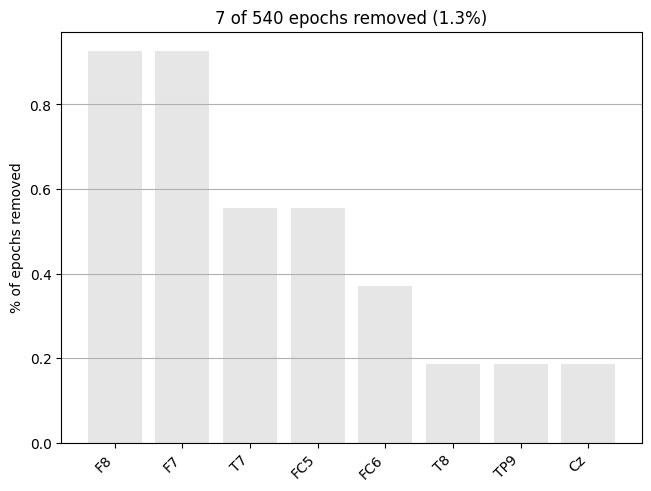

Group12


In [4]:
# epoch to get drop log
# defining the events
event_id = {
        'Word/wPos': 11, # positive word
        'Image/wPos': 21, # positive image (always following pos word) 
        'Word/wNeg': 12, # negative word
        'Image/wNeg': 22, # negative image (always following neg word) 
        'Word/wNeu': 13, # neutral word
        'Image/wNeu/iPos': 41, # positive image (after neu word) 
        'Image/wNeu/iNeg': 42, # negative image (after neu word) 
        'Correct/wPos': 101, # correct response ('b') to pos w + image 
        'Correct/wNeg': 102, # correct response ('y') to neg w + image 
        'Correct/wNeu/iPos': 111, # cor resp ('b') to neu w + pos image 
        'Correct/wNeu/iNeg': 112, # cor resp ('y') to neu w + neg image 
        'Incorrect/wPos': 202, # incor resp ('y') to pos w + image 
        'Incorrect/wNeg': 201, # incor resp ('b') to neg w + image 
        'Incorrect/wNeu/iPos': 212, # incor resp ('y') to neu w + pos i 
        'Incorrect/Neu/iNeg': 211 # incor resp ('b') to neu w + neg i
    }

# creating the events
events, _ = mne.events_from_annotations(raw)

# remove events from event id that are not in the data (to avoid errors when creating the epochs)
event_id_tmp = {key: value for key, value in event_id.items() if value in events[:, 2]}

reject = {"eeg": 100e-6}

raw.info["bads"] = ["Fp1", "Fp2", "CP2"]

# creating the epochs
epochs = mne.Epochs(
            raw, 
            events, 
            event_id=event_id_tmp,
            tmin=-0.2, 
            tmax=0.5, 
            baseline=(-0.2, 0), 
            preload=True, 
            reject=reject
        )


# plot the drop log
epochs.plot_drop_log();
print(participant_path.stem)

In [5]:
from pyts.image import GramianAngularField
import numpy as np


In [6]:
# generate a timeseries

# get the data from the epochs
data = epochs.get_data(copy=True)


timeseries = data[3, 6, :] # third trial, sixth channel, all time points

In [7]:
def min_max_scaling(x, upper_bound=1, lower_bound=-1):
    return (x - np.min(x)) / (np.max(x) - np.min(x)) * (upper_bound - lower_bound) + lower_bound

timeseries = min_max_scaling(timeseries)

True

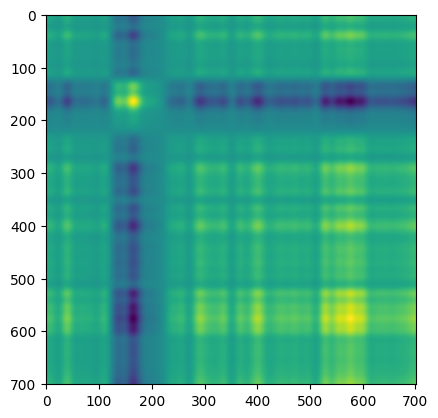

In [8]:
## without gramian angular field

# pairwise dot product
similarity_matrix = np.dot(timeseries.reshape(-1, 1), timeseries.reshape(1, -1))

plt.imshow(similarity_matrix, cmap="viridis")


n, m = 4, 100
similarity_matrix[n, m] == similarity_matrix[m, n]# symmetric around the diagonal

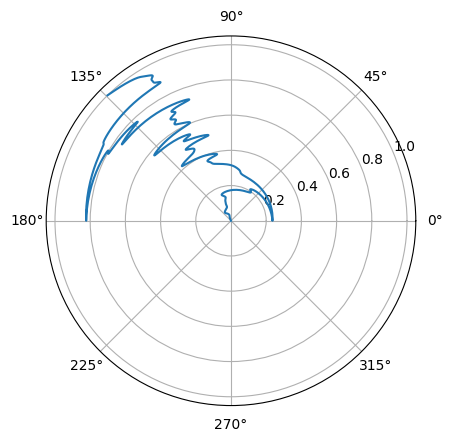

In [9]:
## with gramian angular field

# convert the timeseries polar coordinates
angle = np.arccos(timeseries)

radius = np.linspace(0, 1, len(timeseries))

#plot on a circle
plt.polar(angle, radius)



In [10]:
print(f"min: {np.min(angle)}, max: {np.max(angle)}")

min: 0.0, max: 3.141592653589793


True

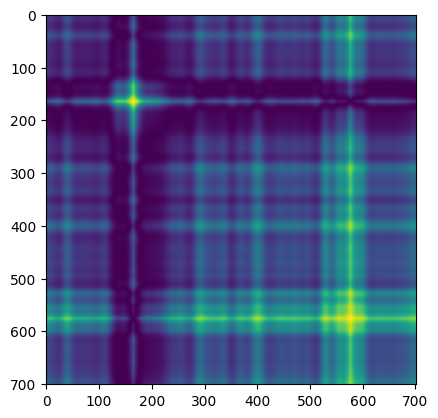

In [11]:
## with gramian angular field

# create the gramian angular field
gasf = GramianAngularField(method="summation")
img = gasf.fit_transform(timeseries.reshape(1, -1)).squeeze()

plt.imshow(img, cmap="viridis")


img[n, m] == img[m, n]# symmetric around the diagonal

([], [])

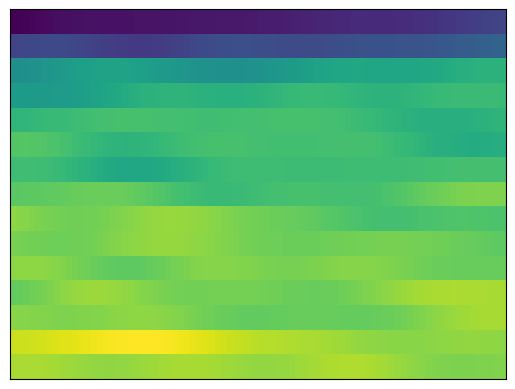

In [12]:
# plot for methods figure

data_plot = data[3, :15, 20:100] # third trial, all channels, some time points

data_plot = min_max_scaling(data_plot, upper_bound=1, lower_bound=-1)

plt.imshow(data_plot, aspect="auto", cmap="viridis")

# remove ticks
plt.xticks([])
plt.yticks([])


(-0.5, 79.5, 0.5, -0.5)

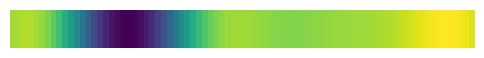

In [13]:
# plot just one sensor
data_plot = data[3, 6, 20:100] # third trial, sixth channel, some time points

timeseries = min_max_scaling(data_plot, upper_bound=1, lower_bound=-1)

fig, ax = plt.subplots(figsize=(6, 0.5))


ax.imshow(timeseries.reshape(1, -1), cmap="viridis", aspect="auto")
ax.axis("off")


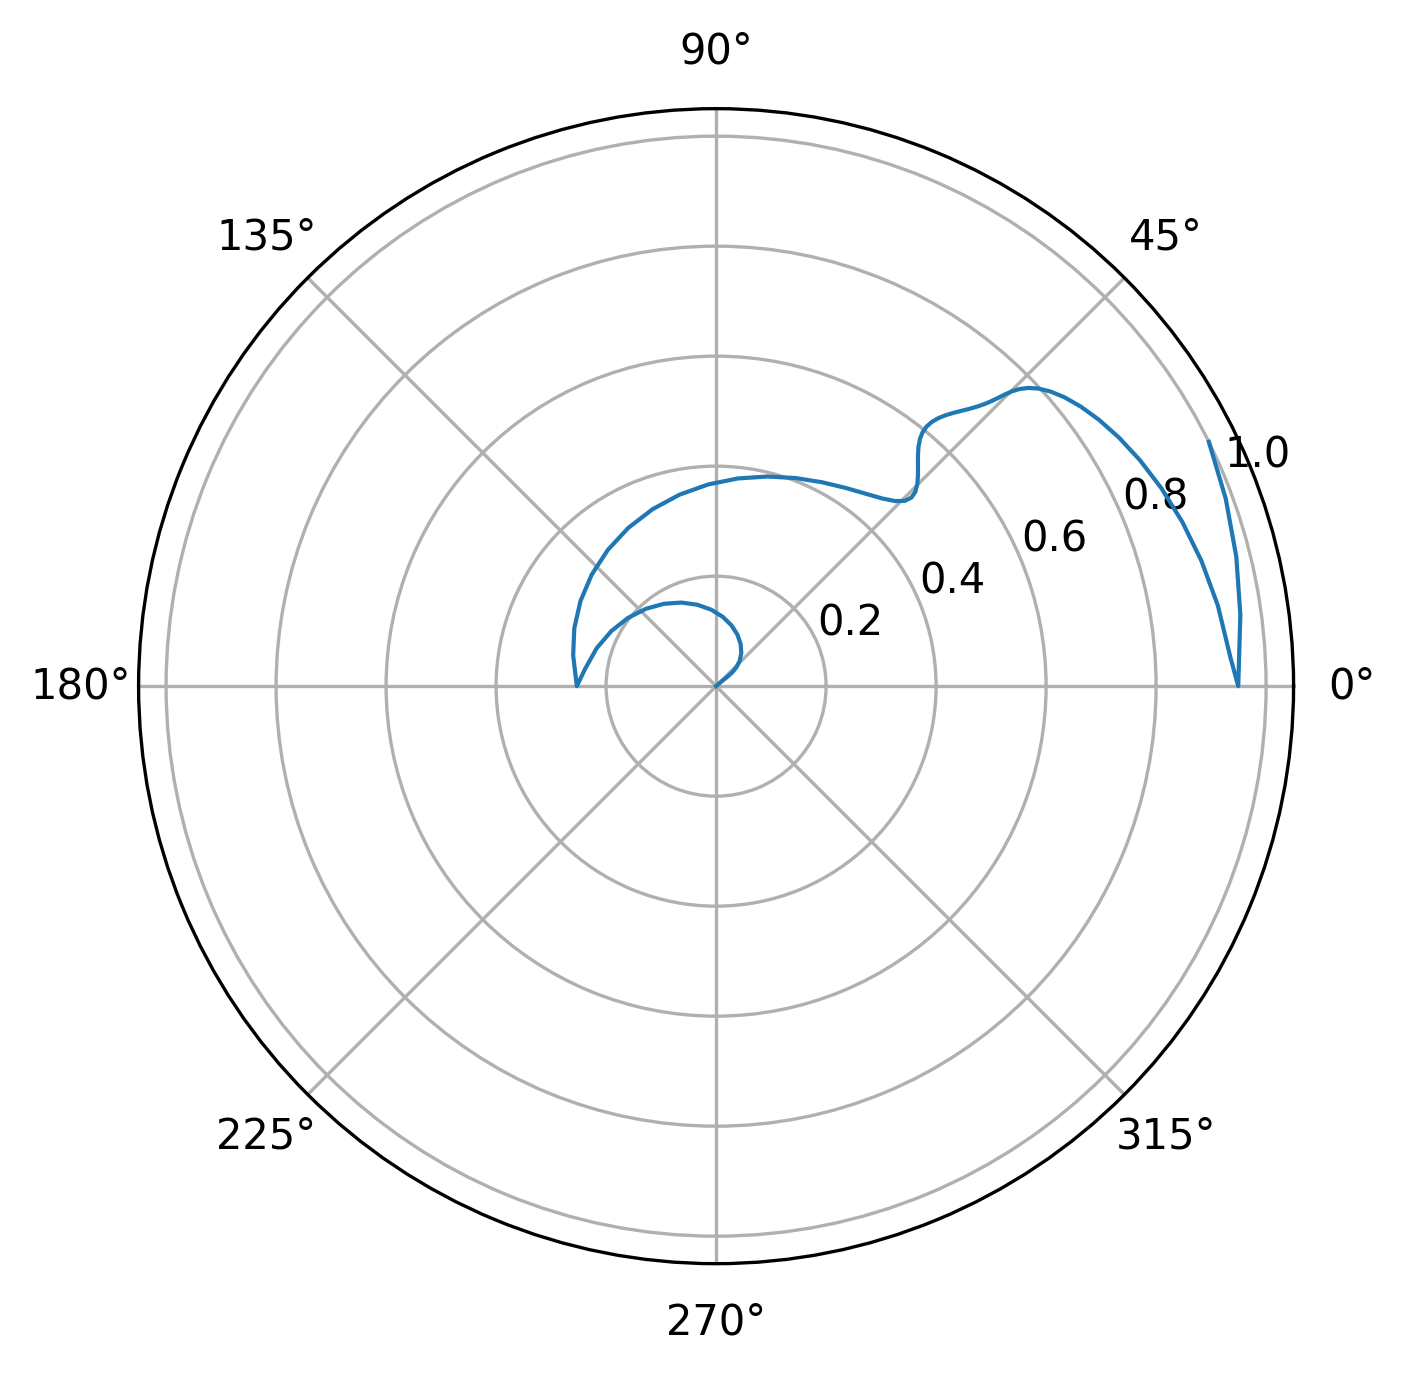

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=300, subplot_kw={'projection': 'polar'})


# convert the timeseries polar coordinates
angle = np.arccos(timeseries)

radius = np.linspace(0, 1, len(timeseries))

#plot on a circle
ax.plot(angle, radius, linewidth=1)




(-0.5, 79.5, 79.5, -0.5)

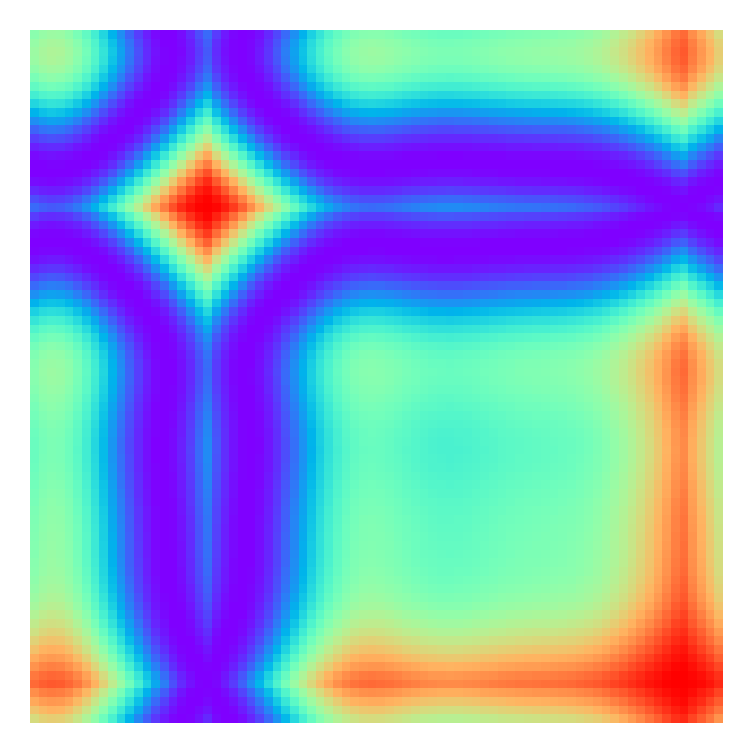

In [15]:
## plot the gramian angular field
gasf = GramianAngularField(method="summation")
img = gasf.fit_transform(timeseries.reshape(1, -1)).squeeze()

fig, ax = plt.subplots(1, 1, figsize=(3,3), dpi=300)


ax.imshow(img, cmap="rainbow")
ax.axis("off")


In [16]:
# convert the timeseries polar coordinates
angle = np.arccos(timeseries)

radius = np.linspace(0, 1, len(timeseries))

# make the gramian angular field

gram_summation = np.array([[np.cos(a1 + a2) for a1 in angle] for a2 in angle])
gram_difference = np.array([[np.cos(a1 - a2) for a1 in angle] for a2 in angle])


# calculate the correlation between the two methods
correlation = np.corrcoef(gram_summation.flatten(), gram_difference.flatten())[0, 1]
correlation

0.6153332254883684

In [17]:
# make example with markov transition field

n_quantiles = 4

# quantize the timeseries
quantiles = np.quantile(timeseries, np.linspace(0, 1, n_quantiles))

quantized_timeseries = np.digitize(timeseries, quantiles) - 1


# define the transition matrix
transition_matrix = np.zeros((n_quantiles, n_quantiles))

for i in range(len(quantized_timeseries) - 1):
    current_state = quantized_timeseries[i]
    next_state = quantized_timeseries[i+1]

    transition_matrix[current_state, next_state] += 1

# weight the transition matrix
transition_matrix = transition_matrix / np.sum(transition_matrix, axis=1, keepdims=True)

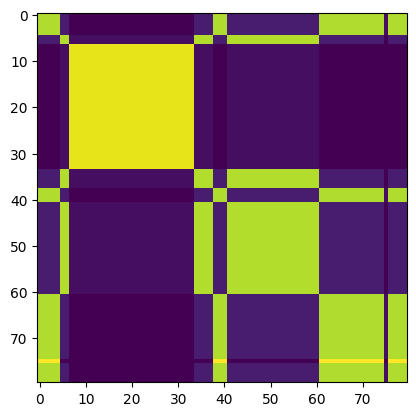

In [18]:
# now that we have the transition matrix, we can calculate the markov transition field
markov_transition_field = np.zeros((len(timeseries), len(timeseries)))

for i in range(len(timeseries)):
    for j in range(len(timeseries)):
        markov_transition_field[i, j] = transition_matrix[quantized_timeseries[i], quantized_timeseries[j]]

plt.imshow(markov_transition_field, cmap="viridis")

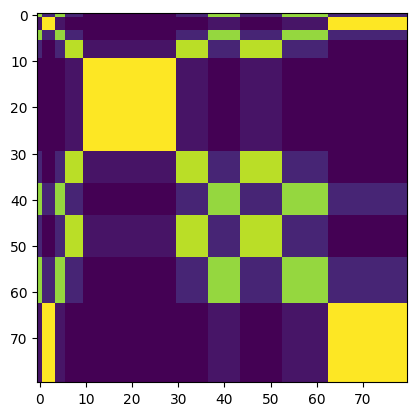

In [19]:
# try with python package
from pyts.image import MarkovTransitionField

mtf = MarkovTransitionField(n_bins=4)
img = mtf.fit_transform(timeseries.reshape(1, -1)).squeeze()

plt.imshow(img, cmap="viridis")


([], [])

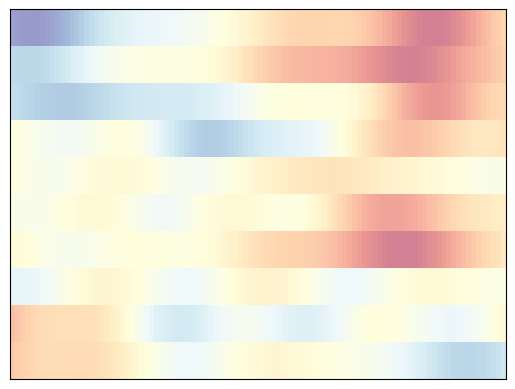

In [34]:
# plot for methods figure

data_plot = data[5, :10, 0:100] # third trial, all channels, some time points

data_plot = min_max_scaling(data_plot, upper_bound=1, lower_bound=-1)

plt.imshow(data_plot, aspect="auto", cmap="RdYlBu", alpha = 0.5)


# remove ticks
plt.xticks([])
plt.yticks([])
